In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from os.path import join
import tqdm
import numpy as np
from torch import optim


from model.model_def_new import SimpleCNN

class AverageValueMeter:
    def __init__(self):
        self.reset()
        self.sum = 0
        self.num = 0

    def reset(self):
        self.sum = 0
        self.num = 0

    def add(self, val, n=1):
        self.sum += val * n
        self.num += n

    def value(self):
        try:
            return self.sum / self.num
        except:
            return None


In [2]:
def train_classifier(model, train_loader, test_loader, exp_name='experiment', lr=0.01, epochs=10, momentum=0.99,
                     logdir='logs'):
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    criterion = nn.CrossEntropyLoss()
    writer = SummaryWriter(join(logdir, exp_name))
    loss_meter = AverageValueMeter()
    acc_meter = AverageValueMeter()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Device:", device)
    model.to(device)

    loader = {
        'train': train_loader,
        'test': test_loader
    }

    global_step = 0

    for e in range(epochs):
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            loss_meter.reset()
            acc_meter.reset()

            with torch.set_grad_enabled(phase == 'train'):
                with tqdm.tqdm(enumerate(loader[phase]), total=len(loader[phase]),
                               desc=f"{phase.capitalize()} Epoch {e + 1}/{epochs}", unit="batch") as pbar:
                    for i, batch in pbar:

                        x = batch[0].to(device)
                        y = batch[1].to(device)
                        output = model(x)

                        n = x.shape[0]
                        global_step += n
                        loss = criterion(output, y)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            optimizer.zero_grad()
                            # scheduler.step(loss)

                        accuracy = accuracy_score(y.to('cpu'), output.to('cpu').max(1)[1])
                        loss_meter.add(loss.item(), n)
                        acc_meter.add(accuracy, n)

                        pbar.set_postfix(loss=loss_meter.value(), accuracy=acc_meter.value())

                        if phase == 'train':
                            writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                            writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step)
            writer.add_scalar('loss/' + phase, loss_meter.value(), global_step=global_step)
            writer.add_scalar('accuracy/' + phase, acc_meter.value(), global_step=global_step)

        torch.save(model.state_dict(), '%s-%d.pth' % (exp_name, e + 1))

    return model


In [3]:
def test_classifier_v2(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model.to(device)
    model.eval()

    predictions, labels = [], []

    with torch.no_grad():
        with tqdm.tqdm(loader, desc="Testing", unit="batch") as pbar:
            for batch in pbar:
                x = batch[0].to(device)
                y = batch[1].to(device)
                output = model(x)
                preds = output.to("cpu").max(dim=1)[1]
                labs = y.to("cpu").numpy()
                predictions.extend(list(preds))
                labels.extend(list(labs))

    return np.array(predictions), np.array(labels)


In [4]:
sign_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'T', 'U', 'V', 'W', 'X',
               'Y']

dict_alph = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'h': 6,
    'i': 7,
    'k': 8,
    'l': 9,
    'm': 10,
    'n': 11,
    'o': 12,
    'p': 13,
    'q': 14,
    'r': 15,
    't': 16,
    'u': 17,
    'v': 18,
    'w': 19,
    'x': 20,
    'y': 21
}


In [5]:
from torchvision import transforms
import os
from PIL import Image
import torch

DATASET1_FOLDER = "DataAcquisition/pythonProject/Dataset_Elvio"
DATASET2_FOLDER = "DataAcquisition/pythonProject/Dataset_Manuel"
DATASET3_FOLDER = "DataAcquisition/pythonProject/Dataset_Michele"
# DATASET4_FOLDER = "DataAcquisition/pythonProject/Dataset_Juliana"

DATASET_ESTESO = 'DataAcquisition/pythonProject/Dataset_michele_esteso/'
DATASET2_ESTESO = "DataAcquisition/pythonProject/Dataset_Elvio_esteso_black_background"
datasets = [DATASET2_FOLDER,DATASET_ESTESO,DATASET2_ESTESO]
#letters = ['a','b','c','d','e', 'f', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 't', 'u', 'v', 'w', 'x', 'y']

#datasets = [DATASET_ESTESO]

"""
# Collect all images to compute mean and std
all_images = []

for letter in dict_alph:

    for dataset in datasets:
        sub_folder = dataset + '/' + letter

        for img_name in os.listdir(sub_folder):
            im = transform(Image.open(sub_folder + '/' + img_name))
            label = dict_alph[img_name[0]]
            data.append((im, label))
            all_images.append(im) """

"\n# Collect all images to compute mean and std\nall_images = []\n\nfor letter in dict_alph:\n\n    for dataset in datasets:\n        sub_folder = dataset + '/' + letter\n\n        for img_name in os.listdir(sub_folder):\n            im = transform(Image.open(sub_folder + '/' + img_name))\n            label = dict_alph[img_name[0]]\n            data.append((im, label))\n            all_images.append(im) "

In [6]:
""" # Stack all images to form a 4D tensor (N, C, H, W)
all_images_tensor = torch.stack(all_images)

# Compute mean and std along the channel dimension
mean = all_images_tensor.mean(dim=[0, 2, 3])
std = all_images_tensor.std(dim=[0, 2, 3])
print("Mean: ", mean)
print("Std: ", std) """

' # Stack all images to form a 4D tensor (N, C, H, W)\nall_images_tensor = torch.stack(all_images)\n\n# Compute mean and std along the channel dimension\nmean = all_images_tensor.mean(dim=[0, 2, 3])\nstd = all_images_tensor.std(dim=[0, 2, 3])\nprint("Mean: ", mean)\nprint("Std: ", std) '

In [7]:
"""transform_aug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    #transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std),
])

 data = []

for letter in dict_alph:
    for dataset in datasets:
        sub_folder = os.path.join(dataset, letter)
        for img_name in os.listdir(sub_folder):
            img_path = os.path.join(sub_folder, img_name)
            im = transform(Image.open(img_path))
            label = dict_alph[img_name[0]]
            data.append((im, label))
print(data[0][0].shape)  # Should be (1, 64, 64) for grayscale images """

'transform_aug = transforms.Compose([\n    transforms.Grayscale(num_output_channels=1),\n    #transforms.Resize((64, 64)),\n    transforms.RandomHorizontalFlip(0.5),\n    transforms.RandomRotation(15),\n    transforms.ToTensor(),\n    # transforms.Normalize(mean=mean, std=std),\n])\n\n data = []\n\nfor letter in dict_alph:\n    for dataset in datasets:\n        sub_folder = os.path.join(dataset, letter)\n        for img_name in os.listdir(sub_folder):\n            img_path = os.path.join(sub_folder, img_name)\n            im = transform(Image.open(img_path))\n            label = dict_alph[img_name[0]]\n            data.append((im, label))\nprint(data[0][0].shape)  # Should be (1, 64, 64) for grayscale images '

In [8]:
transform_aug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomPerspective(0.3,0.2),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std),
])

transform_base = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std),
])


# DATASET CREATION WITH NEW DATA AUG 
data = []

for letter in dict_alph:
    for dataset in datasets:
        sub_folder = os.path.join(dataset, letter)
        for img_name in os.listdir(sub_folder):
            img_path = os.path.join(sub_folder, img_name)
            im0 = transform_base(Image.open(img_path))
            im1 = transform_aug(Image.open(img_path))
            #im2 = transform_aug(Image.open(img_path))
            label = dict_alph[img_name[0]]
            data.append((im0, label))
            data.append((im1, label))
            #data.append((im2, label))
print(data[0][0].shape)  # Should be (1, 64, 64) for grayscale images
print("DATASET SIZE:",len(data))

torch.Size([1, 64, 64])
DATASET SIZE: 158498


In [9]:
from sklearn.model_selection import train_test_split


def split_train_val_test(dataset, perc=None):  # default 60% train, 10% val, 30% test

    if perc is None:
        perc = [0.6, 0.3]
    train, test = train_test_split(dataset, test_size=perc[1], train_size=perc[0])

    return train, test


train, test = split_train_val_test(data, [0.7, 0.3])

print("Train size: ", len(train))
print("Test size: ", len(test))

Train size:  110948
Test size:  47550


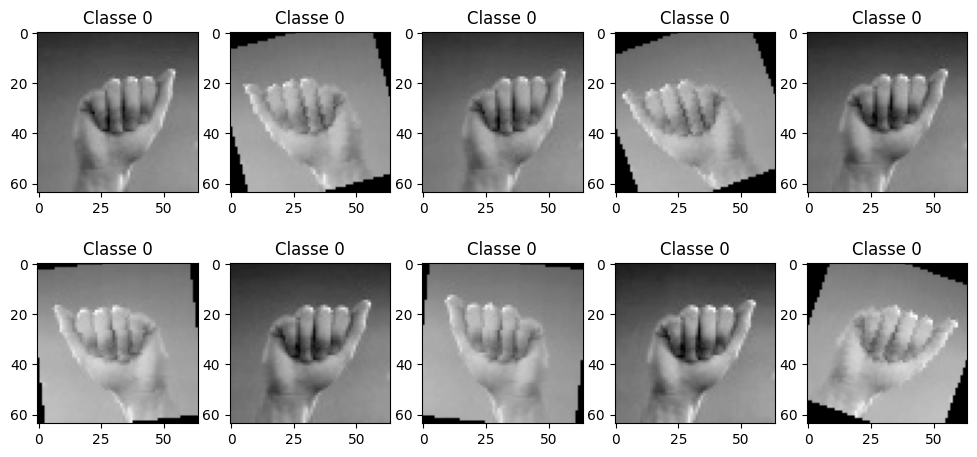

In [10]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,5.5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title("Classe %d" % data[i][1])
    plt.imshow(data[i][0].permute(1, 2, 0), cmap='gray')
plt.show()

In [11]:
from torch.utils.data import DataLoader

train_data = DataLoader(train, batch_size=64, num_workers=2, shuffle=True)
test_data = DataLoader(test, batch_size=64, num_workers=2)

# SCELTA VARIABILE CON PRESET PARAMETRI O CON SINGOLO PARAMETRO

In [12]:
with_preset = False

In [3]:
from torchsummary import summary
from model.model_def_new import SimpleCNN
from model.model_def_v1 import SignLanguage_DeepCNN

if not with_preset:
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        #model = SimpleCNN().cuda()
        model = SignLanguage_DeepCNN().cuda()
    model_name = "SignLanguage_DeepCNN_WithMoreDropout_WithDA_LessParams"

In [4]:
if not with_preset: 
    summary(model, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             160
              ReLU-2           [-1, 16, 64, 64]               0
         MaxPool2d-3           [-1, 16, 32, 32]               0
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 32, 32, 32]           4,640
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
           Flatten-8                 [-1, 8192]               0
           Dropout-9                 [-1, 8192]               0
           Linear-10                  [-1, 128]       1,048,704
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 22]           2,838
Total params: 1,056,374
Trainable params: 1,056,374
Non-trainable params: 0
---------------------------

In [15]:
if not with_preset:
    preset_parametri_sign = [['_lr_0001_mom90_ep20_elvio', 0.0001, 0.90, 20]]
    
    for preset in preset_parametri_sign:
        exp_name = model_name + preset[0]
        print("Experiment Name: ", exp_name, ", with parameters: ", "lr= ", preset[1], "momentum= ", preset[2], "epochs= ",
              preset[3])
        train_classifier(model, train_data, test_data, exp_name=exp_name, lr=preset[1], momentum=preset[2],
                         epochs=preset[3], logdir='Logs')
        test_result = test_classifier_v2(model, test_data)
        torch.save(model, exp_name + '.pt')
    
        counter = 0
    
        for i in range(len(test_result[0])):
            # print("TEST_RESULTS = ", test_result[0][i], ", " , test_result[1][i])
            if sign_labels[test_result[0][i]] == sign_labels[test_result[1][i]]:
                counter += 1
    
    
        print("Experiment Name: ", exp_name, " Accuracy: ", counter / len(test_result[0]), " || ", counter, "/",
              len(test_result[0]))
        print("\n\n")

Experiment Name:  SignLanguage_DeepCNN_WithMoreDropout_WithDA_LessParams_lr_0001_mom90_ep20_elvio , with parameters:  lr=  0.0001 momentum=  0.9 epochs=  20
Device: cuda


Testing: 100%|██████████| 743/743 [00:09<00:00, 77.66batch/s] 

Experiment Name:  SignLanguage_DeepCNN_WithMoreDropout_WithDA_LessParams_lr_0001_mom90_ep20_elvio  Accuracy:  0.9752260778128286  ||  46372 / 47550





In [16]:
%load_ext tensorboard
%tensorboard --logdir Logs --port=6977

# TRAINING ALTERNATIVO CON PIU' PARAMETRI E RESET DEL MODELLO

In [17]:
if with_preset:
    use_cuda = torch.cuda.is_available()

    preset_parametri_sign = [['_lr001_mom90_ep100', 0.001, 0.90, 100], ['_lr001_mom90_ep50', 0.001, 0.90, 50],['_lr001_mom99_ep50', 0.001, 0.99, 50],['_lr0001_mom90_ep100', 0.0001, 0.90, 100],
                             ['_lr001_mom90_ep150', 0.001, 0.90, 150], ['_lr001_mom99_ep150', 0.001, 0.99, 150], ['_lr0001_mom99_ep150', 0.001, 0.90, 150]]

    for preset in preset_parametri_sign:

        if use_cuda:
            model = SimpleCNN().cuda()
        model_name = "Parameter-SimpleCNN"

        exp_name = model_name + preset[0]
        print("Experiment Name: ", exp_name, ", with parameters: ", "lr= ", preset[1], "momentum= ", preset[2], "epochs= ",
              preset[3])
        train_classifier(model, train_data, test_data, exp_name=exp_name, lr=preset[1], momentum=preset[2],
                         epochs=preset[3], logdir='Logs')
        test_result = test_classifier_v2(model, test_data)
        torch.save(model, exp_name + '.pt')

        counter = 0

        for i in range(len(test_result[0])):
            # print("TEST_RESULTS = ", test_result[0][i], ", " , test_result[1][i])
            if sign_labels[test_result[0][i]] == sign_labels[test_result[1][i]]:
                counter += 1


        print("Experiment Name: ", exp_name, " Accuracy: ", counter / len(test_result[0]), " || ", counter, "/",
              len(test_result[0]))
        print("\n\n")

In [18]:
%load_ext tensorboard
%tensorboard --logdir logs --port=6976

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6976 (pid 108272), started 1:49:31 ago. (Use '!kill 108272' to kill it.)